<a href="https://colab.research.google.com/github/shahzaibkhan/learning-langchain/blob/main/Learning_LangChain_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Learning Index by Developing your own Chatgpt**
The goal of this lesson is to let you create a chatbot trained on your data using ChatGPT.

Other use cases which may use similar concept include:

*  Customer Support Bot
*  Company internal knowledge sharing app
*  Document Search

So lets start.

## **How to achieve this ?**

We can feed all our document data to Langchain and make it answer questions but it is not scalable as ChatGPT has input character limit.

Thus as an alternative, we split the entire input documents into chunks and train our chatbot on it. Now when a user asks a query, only the relevant documents are fetched and passed on to ChatGPT. Since the data input to ChatGPT is only relevant text data and not the entire data, there is no problem with input limit.

We implement this in Langchain using **Indexes.**

## **Embeddings**

Before we start with Langchain indexes we should understand embeddings. As humans we can understand language with quite ease but computers only understand numbers. Thus if we have to feed text as input to a computer, we have to convert it to numbers. But these number can't be any random number, they should preserve the meaning of the text input. This is where embeddings come.

Embeddings are an index of text string relatedness and are expressed by a vector (list) of floating point integers. The distance between two vectors serves as a measure of how closely connected they are; the smaller the distance, the closer the relatedness. The LangChain Embedding class is intended to serve as an interface for embedding services such as OpenAI, HuggingFace, and others.

To read more about it, can refer: https://towardsdatascience.com/all-you-need-to-know-to-build-your-first-llm-app-eb982c78ffac#335e

Now that we understand embeddings, OpenAI has a LLM called Ada which can convert text into embeddings. Langchain uses it to create embeddings for any text.

## **Vector db**
We have created embeddings for the input text but we need a way to store it and make quick queries. Traditional database are not designed for these tasks. Thus we need a specialized database for this task called as Vector db which allows for quick retrieval of vectors

There are many popular vector db available in the market. Langchain uses Chroma db by default. It is free to use and runs.

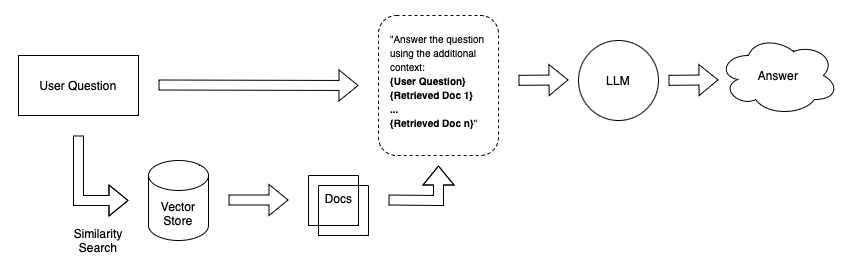

Here is the entire flow for question answering with our chatbot

1. User asks a question
2. A similarity search is performed to identify all similar text from our vector store/db
3. The user question combined with the relevant documents are passed to ChatGPT and the answer is generated

Lets now implement this:

In [1]:
#Install dependencies

!pip install langchain
!pip install openai
!pip install tiktoken
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.1/965.1 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 102.5 M

In [2]:
#Download sample training data

!wget https://raw.githubusercontent.com/hwchase17/chat-your-data/master/state_of_the_union.txt

--2023-06-30 15:00:22--  https://raw.githubusercontent.com/hwchase17/chat-your-data/master/state_of_the_union.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39027 (38K) [text/plain]
Saving to: ‘state_of_the_union.txt’

state_of_the_union. 100%[===================>]  38.11K  --.-KB/s    in 0.002s  

2023-06-30 15:00:22 (18.9 MB/s) - ‘state_of_the_union.txt’ saved [39027/39027]



In [3]:
# Document Loader is a Langchain abstract which helps you fetch training data from various sources such as a webpage, youtube video, notion doc etc.
# For this example we need to load a text document. Thus we will be using TextLoader

from langchain.document_loaders import TextLoader
loader = TextLoader('state_of_the_union.txt', encoding='utf8')
documents = loader.load()

In [4]:
# Document Splitter: As discussed, we take the documents and split them into chunks before we create embeddings and store them. For this we use document splitters.
# There are various document splitters Langchain supports.
# We will be using a simple TextSplitter which splits the documents based on character limit.
# When splitting we allow a overlap of few characters across consecutive splits such that the context is not broken and is passed across both the documents.

from langchain.text_splitter import CharacterTextSplitter
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
texts = text_splitter.split_documents(documents)

In [5]:
# Let's create the embeddings for these chunks now and store them in our vectorstore Chromadb.
# This creates an index which contains all this information. P
# Note: Place your OpenAI key in place of your-openai-key

from langchain.embeddings import OpenAIEmbeddings
import os
from langchain.vectorstores import Chroma

os.environ["OPENAI_API_KEY"] = "your-openai-key"

embeddings = OpenAIEmbeddings()
db = Chroma.from_documents(texts, embeddings)

In [6]:
# Now we can create a Q&A chain to which we can make queries and get answers based on our training data powered by ChatGPT.
# The Q&A chain needs as input a retriever created from our index above

from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

retriever = db.as_retriever()
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=retriever)

In [7]:
#Now we can make any queries to our Q&A chain and get answer powered by ChatGPT

query = "What did the president say about Ketanji Brown Jackson"
qa.run(query)

" The president said that Ketanji Brown Jackson is one of the nation's top legal minds, a former top litigator in private practice, a former federal public defender, from a family of public school educators and police officers, a consensus builder, and has received a broad range of support from the Fraternal Order of Police to former judges appointed by Democrats and Republicans."

In [8]:
# Lets do another

query = "Who was President Zelenskyy?"
qa.run(query)

' President Zelenskyy was the President of Ukraine mentioned in the context.'